In [1]:
import os
import sys
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import ast
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
sys.path.insert(0, os.path.abspath("../../" + 'src/scraping'))
import metadata as meta
sys.path.insert(0, os.path.abspath("../../" + "src/modeling"))
import basic_stats as basic
import time
from PIL import Image
import datetime

In [2]:
def get_all_thumbnails(save_dir, chan_ids, master_df):
    for chan_id in chan_ids:
        chan_df = master_df[master_df['channelId'] == chan_id]
        chan_vids = meta.download_df_thumbs(chan_df,save_dir,'medium')
    chan_basic_df = basic.basic_image_stats(save_dir)
    full_chan = master_df.merge(chan_basic_df,on='videoId')
    full_chan = full_chan.drop_duplicates(subset='videoId')
    return full_chan

def get_corr(img_feats, meta_feats,df,sign):
    corrs = []
    for col in meta_feats:
        for col2 in img_feats:
            step1 = df[df[col].notnull()]
            filtered = step1[step1[col2].notnull()]
            corr = np.corrcoef(filtered[col],filtered[col2])[0][1]
            corrs.append([col2, col, corr])
    corr_df = pd.DataFrame(corrs, columns=['img_ft','meta_ft','corr'])
    return corr_df


# plots single emoition vs z views for all specified emotions
def get_emotions_df(emotions,in_df,meta_col):
    emotions_data = []
    for targ in emotions:
        emotion = in_df['emotions'].apply(lambda x: targ in x if type(x) == str else x)
        emotions_data.append(in_df[emotion == True][meta_col].describe())
    emotions_df = pd.DataFrame(emotions_data).reset_index()
    emotions_df['emotion'] = emotions
    return emotions_df
                    
def get_range(col_name, df):
    stats = df[col_name].describe()
    col_range = np.arange(stats['25%'],stats['max'],stats['std']/3)
    return col_range

def tune_params(df, c1, c2, meta_col):
    baseline_stats = df[meta_col].describe()
    base_mean = baseline_stats['mean']
    base_median = baseline_stats['50%']
    rel_stats = []
    c1_range = get_range(c1,df)
    c2_range = get_range(c2,df)
    for c1_cutoff in c1_range:
        for c2_cutoff in c2_range:
            filtered = df.apply(lambda x: x[c1] > c1_cutoff and x[c2] > c2_cutoff,axis=1)
            stats = df[filtered][meta_col].describe()
            cur_count = stats['count']
            cur_mean = stats['mean']
            cur_median = stats['50%']
            cur_stats_list = [c1,c1_cutoff,c2,c2_cutoff,cur_count, cur_mean, cur_median]
            rel_stats.append(cur_stats_list)
    res_df = pd.DataFrame(rel_stats, columns=['col1','col1cutoff','col2','col2cutoff','count','mean','median'])
    relevant_df = res_df[res_df['count'] > 0] # gets rid of param combinations with no results
    # filters out param combinations that did worse than the baseline
    better_df = relevant_df[relevant_df.apply(
        lambda x: x['mean'] > base_mean and x['median'] > base_median,axis=1)]
    return better_df

In [3]:
# config variables
data_path = "../../data/local/fortnite/video_data/fortnite_full_features_05_22_20.csv"
emotions = ['angry', 'happy', 'sad', 'fear', 'neutral', 'surprise']
describe_cols = ['mean','std','25%','50%','75%']
numerical_img_feats = ['unique_rgb_ratio','mean_hue',
                       'mean_saturation','mean_brightness', 'contrast',
                       'edge_score','numFaces']
meta_feats = ['viewCount','z_views']
master_df = pd.read_csv("../../data/local/fortnite/video_data/fortnite_master_metadata_updated_facial_features.csv")
save_dir = "../../data/local/fortnite/thumbnails/"
chan_ids = master_df['channelId'].value_counts().index

In [4]:
# load the dataset
loaded_df = pd.read_csv(data_path)
final_df = loaded_df[loaded_df['z_views'].notnull()]

# different subsets of large local data
face_data = final_df[final_df['numFaces'].notnull()]
no_face_data = final_df[final_df['numFaces'].isnull()]
all_face = final_df.fillna(value={"numFaces":0})

# choose dataset to use for eda
analysis_df = all_face

# this is the original 9800 dataset for dev purposes 
analysis_df = pd.read_csv("../../data/local/fortnite/video_data/fortnite_full_features_05_22_20.csv")

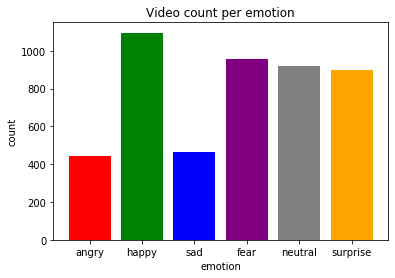

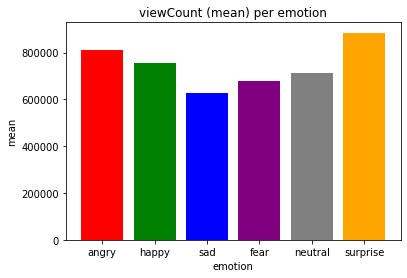

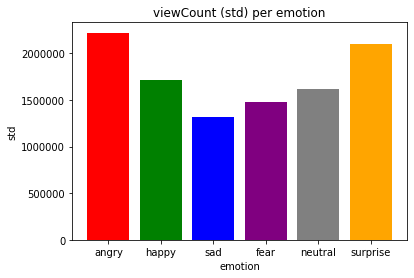

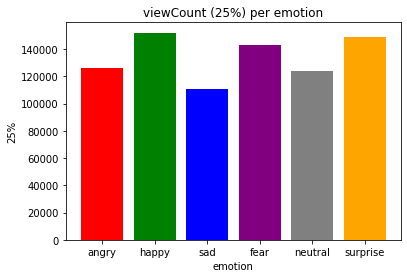

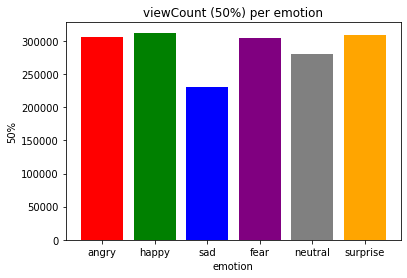

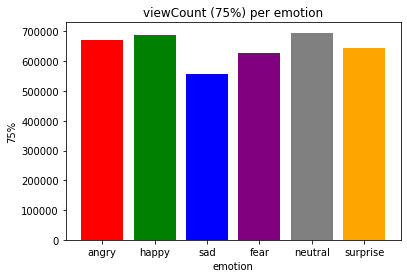

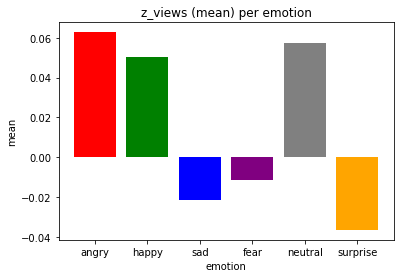

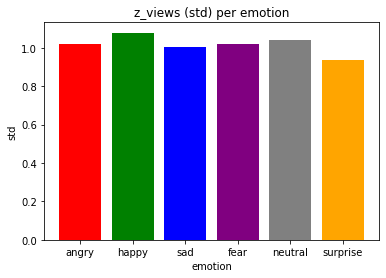

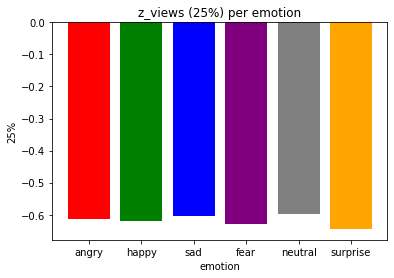

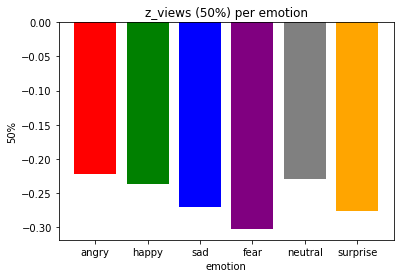

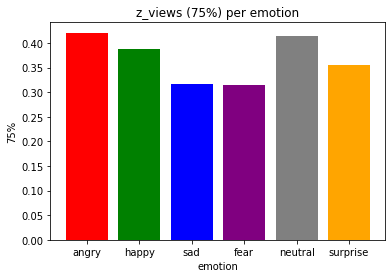

In [23]:
# emotion stats for each descriptive stat for each meta column
plt.rcParams['figure.figsize'] = [6, 4]
emotions_df = get_emotions_df(emotions,analysis_df,meta_feats[0])
plt.bar(emotions_df['emotion'],emotions_df['count'],color=['red','green','blue','purple','grey','orange'])
plt.xlabel('emotion')
plt.ylabel('count')
plt.title("Video count per emotion")
plt.show()
for meta_feat in meta_feats:
    emotions_df = get_emotions_df(emotions,analysis_df,meta_feat)
    for col in describe_cols:
        plt.bar(emotions_df['emotion'],emotions_df[col],color=['red','green','blue','purple','grey','orange'])
        plt.xlabel('emotion')
        plt.ylabel(col)
        plt.title(meta_feat + " (" + col + ") per emotion")
        plt.show()

In [24]:
# table of corr coeffecients for convenience
all_corrs = get_corr(numerical_img_feats, meta_feats, analysis_df, '-')
all_corrs

,img_ft,meta_ft,corr
0,unique_rgb_ratio,viewCount,-0.006591
1,mean_hue,viewCount,0.034842
2,mean_saturation,viewCount,-0.022539
3,mean_brightness,viewCount,0.054719
4,contrast,viewCount,-0.043900
5,edge_score,viewCount,-0.107582
6,numFaces,viewCount,0.035350
7,unique_rgb_ratio,z_views,0.044553
8,mean_hue,z_views,-0.010945
9,mean_saturation,z_views,0.026254


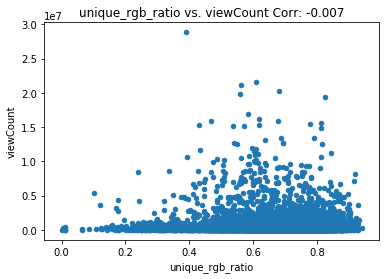

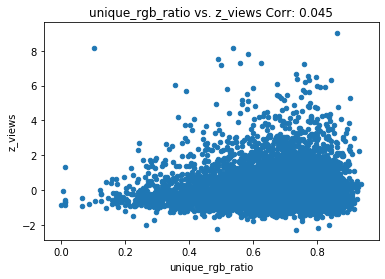

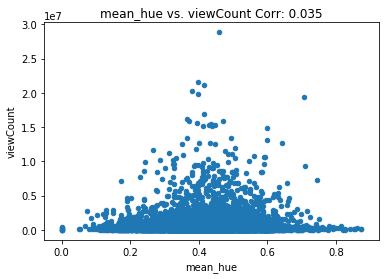

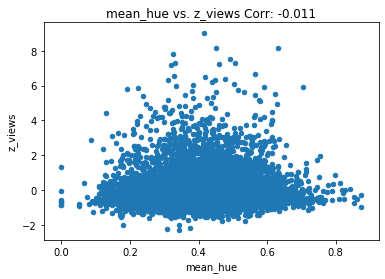

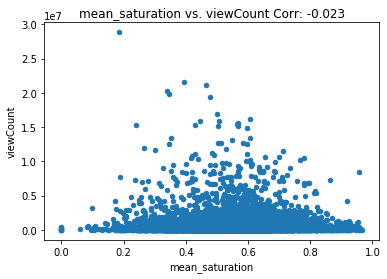

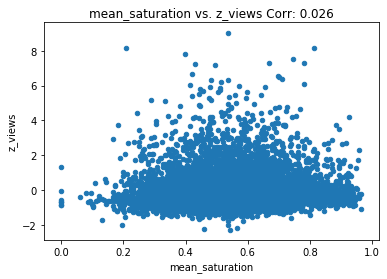

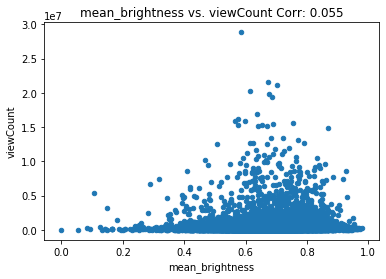

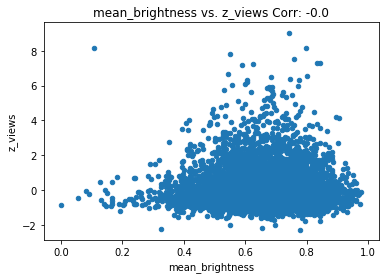

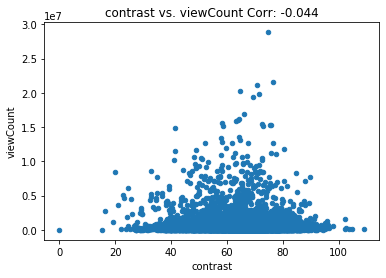

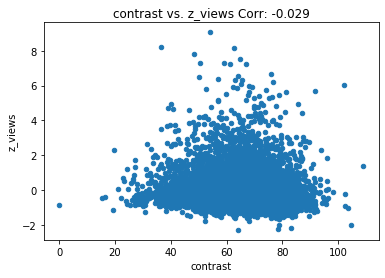

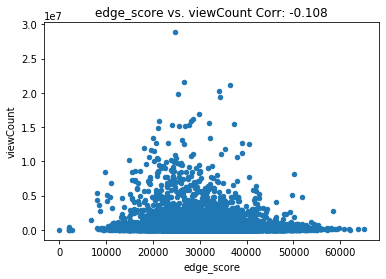

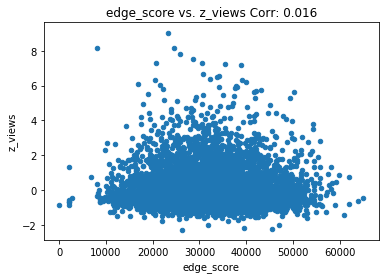

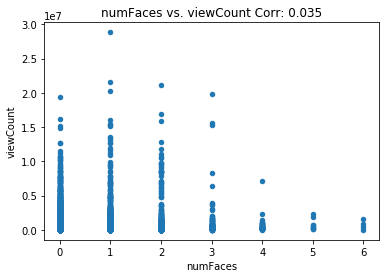

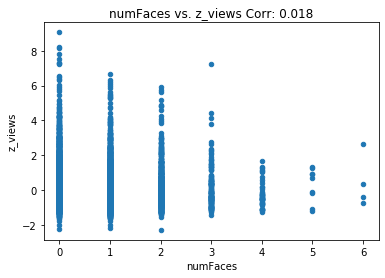

In [26]:
# plot summary of each numerical image feature vs each meta column with correlation in title
for col in numerical_img_feats:
    for meta_col in meta_feats:
        plt.scatter(analysis_df[col],analysis_df[meta_col],s=20)
        plt.xlabel(col)
        plt.ylabel(meta_col)
        cur_corr_df = all_corrs[all_corrs.apply(lambda x: x['img_ft'] == col and x['meta_ft'] == meta_col,axis=1)]
        cur_corr = cur_corr_df.iloc[0]['corr']
        plt.title(col + " vs. " + meta_col + " Corr: " + str(cur_corr.round(3)))
        plt.show()

In [27]:
summary_df = pd.DataFrame()
for meta_feat in meta_feats:
    cur_corr_df = all_corrs[all_corrs['meta_ft'] == meta_feat]
    c1, c2 = cur_corr_df.sort_values(by='corr',ascending=False)['img_ft'].iloc[0:2].values
    # this takes ~2 min bc of the many combinations, may re-write the way I get the ranges
    tuned_df = tune_params(analysis_df,c1,c2,meta_feat) 
    tuned_df['mm_sum'] = tuned_df['mean'] + tuned_df['median']
    #old cell break
    top_df = tuned_df.sort_values(by='mm_sum',ascending=False)
    rgb_cutoff = top_df['col1cutoff'].describe()['mean']
    sat_cutoff = top_df['col2cutoff'].describe()['mean']
    top_cut = analysis_df[analysis_df.apply(
        lambda x: x[c1] > rgb_cutoff and x[c2] > sat_cutoff,axis=1)]

    baseline_stats = analysis_df[meta_feat].describe().round(4)
    baseline_stats['type'] = 'baseline'
    baseline_stats['meta_col'] = baseline_stats.name

    top_cut_stats = top_cut[meta_feat].describe().round(4)
    top_cut_stats['type'] = 'top_cut'
    top_cut_stats['meta_col'] = top_cut_stats.name

    cur_summary_df = pd.DataFrame([baseline_stats,top_cut_stats]).reset_index(drop=True)
    summary_df = pd.concat([summary_df,cur_summary_df])

In [28]:
# analysis using threshold cutoff for 2 features with the highest + correlation to the meta_col
# results are stats of the "top cut" that meet said criteria
summary_df

,count,mean,std,min,25%,50%,75%,max,type,meta_col
0,8688.0,6.863379e+05,1.466804e+06,1074.0000,113880.0000,265476.5000,6.315412e+05,2.883034e+07,baseline,viewCount
1,51.0,1.432502e+06,2.387187e+06,59477.0000,351153.0000,772097.0000,1.386452e+06,1.555928e+07,top_cut,viewCount
0,8688.0,-0.000000e+00,1.000100e+00,-2.2892,-0.6040,-0.2727,2.933000e-01,9.058700e+00,baseline,z_views
1,782.0,6.850000e-02,1.004300e+00,-1.3651,-0.6002,-0.1850,3.898000e-01,6.558300e+00,top_cut,z_views


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF Score: -0.10675766418084276


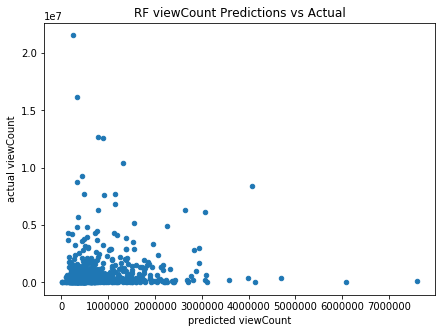

GBR Score: -0.024967898791433463


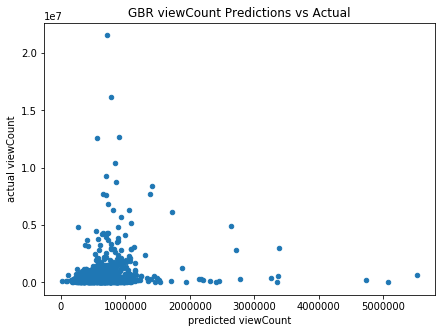

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF Score: -0.118147406031335


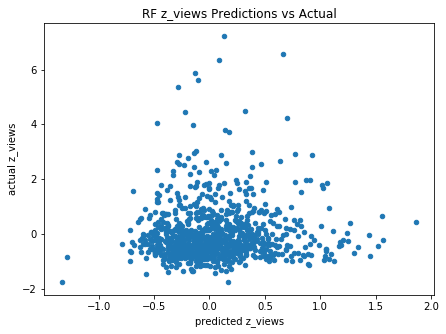

GBR Score: -0.025126267330541907


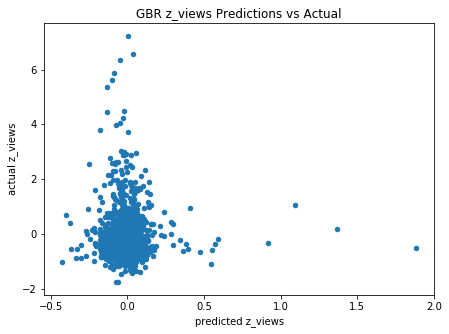

In [89]:
plt.rcParams['figure.figsize'] = [7, 5]
for targ_col in meta_feats:
# targ_col = 'viewCount'
    X_train, X_test, y_train, y_test = train_test_split(analysis_df[numerical_img_feats],
                                                        analysis_df[targ_col],
                                                        train_size=.9)
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    print("RF Score:",rf.score(X_test,y_test))
    plt.scatter(rf_preds,y_test,s=20)
    plt.title('RF ' + targ_col + ' Predictions vs Actual')
    plt.xlabel('predicted '+targ_col)
    plt.ylabel('actual '+targ_col)
    plt.show()
    # feat_importances = pd.Series(dict(zip(numerical_img_feats,rf.feature_importances_)))
    # print("RF Feat Importances:\n",feat_importances.sort_values(ascending=False))
    gbr = GradientBoostingRegressor()
    gbr.fit(X_train,y_train)
    gbr_preds = gbr.predict(X_test)
    print("GBR Score:",gbr.score(X_test,y_test))
    plt.scatter(gbr_preds,y_test,s=20)
    plt.title('GBR ' + targ_col + ' Predictions vs Actual')
    plt.xlabel('predicted '+targ_col)
    plt.ylabel('actual '+targ_col)
    plt.show()

In [57]:
# takes preds to use in google sheets
temp_df = pd.DataFrame(y_test)
temp_df['rf'] = rf_preds
temp_df['gbr'] = gbr_preds
temp_df.to_csv('../../data/local/fortnite/viz_data/ml_preds.csv',index=False)

In [90]:
high_lvl_df = pd.DataFrame()
for num_feat in numerical_img_feats:
    for num_feat2 in numerical_img_feats:
        for num_feat3 in numerical_img_feats:
            for num_feat4 in numerical_img_feats:
                col_name = num_feat + "/" + num_feat2 + "/" + num_feat3 + "/" + num_feat4 
                high_lvl_df[col_name] = analysis_df[num_feat]*analysis_df[num_feat2]*analysis_df[num_feat3]*analysis_df[num_feat4]
# high_lvl_df

LR Score: -0.8534145664467225


Text(0, 0.5, 'actualviewCount')

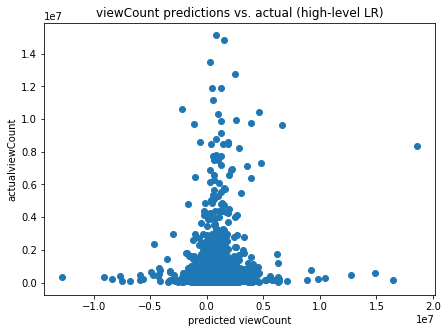

In [93]:
targ_col = "viewCount"
high_train, high_test, targ_train, targ_test = train_test_split(high_lvl_df, analysis_df[targ_col])
lr = LinearRegression()
lr.fit(high_train, targ_train)
print("LR Score:",lr.score(high_test, targ_test))
lr_preds = lr.predict(high_test)
plt.scatter(lr_preds, targ_test)
plt.title(targ_col+" predictions vs. actual (high-level LR)")
plt.xlabel("predicted "+targ_col)
plt.ylabel("actual" + targ_col)

In [5]:
analysis_df['has_face'] = analysis_df['numFaces'] > 0
poor_perf = analysis_df[analysis_df['z_views'] < -1]
good_perf = analysis_df[analysis_df['z_views'] > 1]

In [6]:
poor_data = []
good_data = []
for num_feat in numerical_img_feats:
    poor_data.append(poor_perf[num_feat].describe())
    good_data.append(good_perf[num_feat].describe())
poor_stats = pd.DataFrame(poor_data).drop("count",axis=1).T
good_stats = pd.DataFrame(good_data).drop('count',axis=1).T

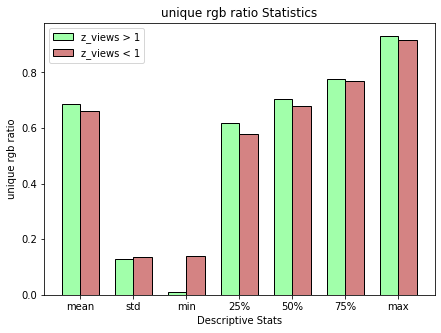

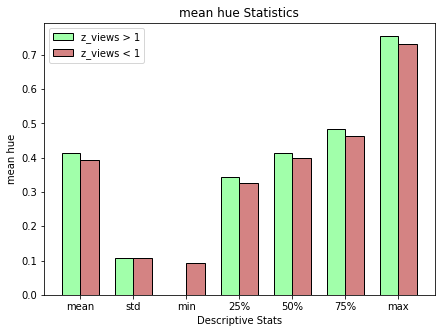

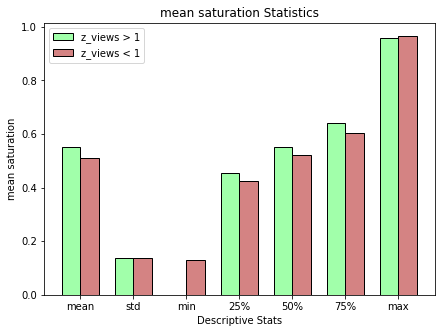

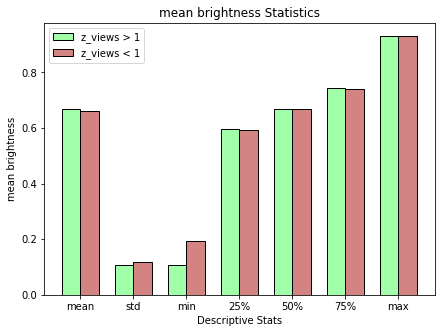

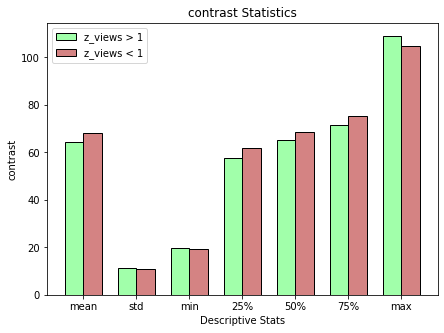

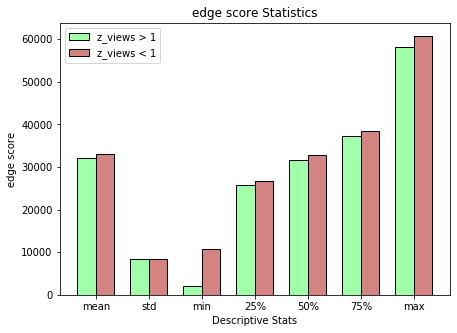

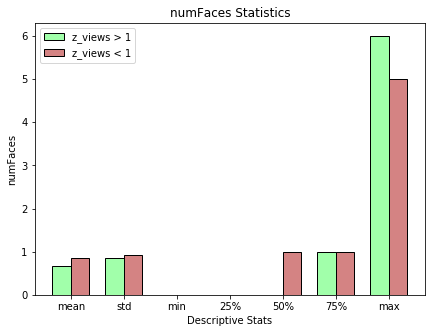

In [7]:
plt.rcParams['figure.figsize'] = [7, 5]
x = np.arange(len(good_stats.index))  # the label locations
width = 0.35  # the width of the bars
for num_feat in numerical_img_feats:
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2,good_stats[num_feat],width,label='z_views > 1',color="#a1ffaa",edgecolor="black")
    rects2 = ax.bar(x + width/2,poor_stats[num_feat],width,label='z_views < 1',color="#d48383",edgecolor="black")
    ax.set_xticks(x)
    ax.set_xticklabels(good_stats.index)
    ax.set_ylabel(num_feat.replace("_", " "))
    ax.set_xlabel("Descriptive Stats")
    ax.set_title(num_feat.replace("_", " ") + " Statistics")
    ax.legend()
    plt.show()

In [14]:
good_rgb = good_perf['unique_rgb_ratio'].values
poor_rgb = poor_perf['unique_rgb_ratio'].values
good_hue = good_perf['mean_hue'].values
poor_hue = poor_perf['mean_hue'].values

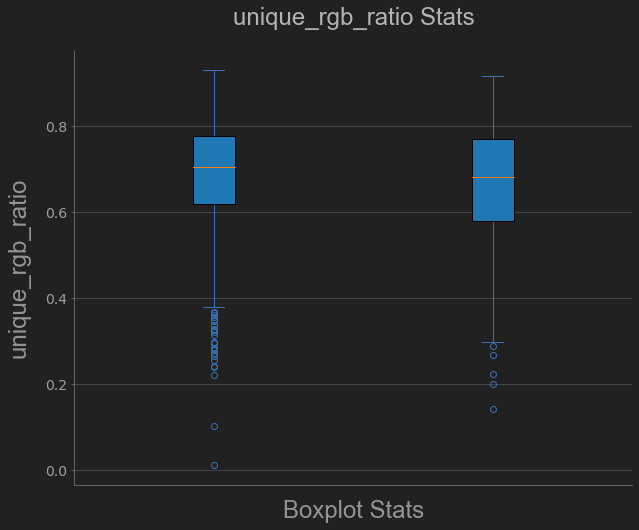

In [51]:
plt.rcParams['figure.figsize'] = [10, 8]
col_name = 'unique_rgb_ratio'
fig, ax = plt.subplots()
c = '#3970b8'
ax.boxplot([good_rgb, poor_rgb],patch_artist=True,
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c))

plt.xticks(range(1),labels=[''],color="white",fontsize=16)

plt.xlabel("Boxplot Stats",color="#949494",fontname="Arial",fontsize=24,labelpad=15)
plt.ylabel(col_name,color="#949494",fontname="Arial",fontsize=24,labelpad=15)
plt.title(col_name + " Stats",fontname='Arial',color='#b3b3b3',fontsize=24,pad=25)
ax.set_facecolor('#212121')
ax.spines['bottom'].set_color('#757575')
ax.spines['top'].set_color('#212121')
ax.spines['right'].set_color('#212121')
ax.spines['left'].set_color('#757575')
ax.tick_params(axis='y', colors='#757575')
fig.patch.set_facecolor('#212121')
plt.yticks(color='#9e9e9e',fontsize=14)
plt.grid(axis='y',color="#4c4f54")
plt.show()